# Solubility Prediction from Molecular Descriptors

The following notebook will provide an introduction of how to explore datasets in Python using the [Pandas](https://pandas.pydata.org/) library, how to prune them down to the data that we need for our analysis, visualisation using [matplotlib](https://matplotlib.org/) and Pandas and finally using machine learning models from [scikit-learn](https://scikit-learn.org/stable/) to build a model which predicts solubility of a solute given the molecular descriptors of the solute and solvent.

## Part 1: Dataset Exploration and Pruning

The first part will be an introduction on how to explore datasets with many separate files in Python and will hopefully demonstrate the usefulness of Pandas and sane data management structures. The first thing to do will be to import the relevant Python packages used in this part of the code: we will be using Pandas and the Python [os](https://docs.python.org/3/library/os.html) standard library. As well as matplotlib for some simple visualisations.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

### Finding the Files

To be able to load the files into Python you need to know where they're stored. That is, you need to know the directory (folder) structure of your filesystem. In this case, the data we are using is stored within a subdirectory of where the code is being run from. This makes locating the data somewhat easier as there is no giant path to prepend to filenames in order to point to the correct locations. All of the data we will be using is in the `solutes` subdirectory. Each file in this subdirectory contains a `.txt` file for each solute we have data for (the names of the files are the solutes) and within each file is a bunch of data corresponding to this solute being dissolved in different solvents. Each file consists of 30 columns and a variable number of rows (not all solvents were tried with all solutes).

* The first 6 columns are: solvent_chem_id, solute_chem_id, solvent_name, solute_name, solute_smile, solvent_smile which are indicators of which materials are used &mdash; this will be shortened to just using the chemical IDs later.
* Then there are the molar heat of fusion of the solute in kJ/mol and melting point of the solute in C. These descriptors are not used in model building however because they are taken from literature a not calculated directly.
* The next column is the solubility of the solute in the solvent measured in g/100g of solvent with the log of this number next to. Then there are model predictions from Cosmo in the next two columns following the same form (these model predictions are also not used since they're bad).
* The last 18 columns are the molecular descriptors of the solute and solvent: there are 9 for each.
  - _a_nC = number of carbon atoms in molecule
  - _a_nN = number of nitrogen atoms in molecule
  - _a_nO = number of oxygen atoms in molecule
  - _b_heavy = number of heavy bonds in molecule
  - _b_rotN = number of rotational bonds
  - _lip_acc = number of H acceptors
  - _lip_don = number of H donors
  - _ring = number of rings
  - _TPSA = total polar surface area (measured in square Angstroms)
  
Despite being `.txt` files, the dataset is really in the [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) (comma-separated values) format but with a tabspace delimiter. What does all that nonsense mean?

CSV files are kind of like Excel files but if you were to open one in Notepad then each cell would be separated by a comma. It is essentially a big table of data but the placement of the commas tells whichever software you are using to read the table where to separate things. In this context, the comma is referred to as a *delimiter*. Commas are not the only delimiters that can be used. Another common delimiter is to use tab as the spacing between the data which is what our data has.

What this means for our code is that we need to remember to include an extra argument in the function reading in the data to tell it that our delimiter is a tab and not a comma. Let's demonstrate this with an example. We will open the `triclosan.txt` file using Pandas and inspect it.

For all files in our dataset we will be using the [pandas.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function to load it into Python. (There also exists a [read_excel](https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html) function which can be used when your data is in `.xlsx` format.

In [2]:
pd.read_csv("solutes/triclosan.txt")

,solvent_chem_id\tsolute_chem_id\tsolvent_name\tsolute_name\tsolute_smiles\tsolvent_smiles\tDHFUS_kj_mol\tTmelt_C\tsolubility_g_100g\tsolubility_g_100g_log\tcosmo_solubility_g_100g\tcosmo_solubility_g_100g_log\tsolute_a_nC\tsolute_a_nN\tsolute_a_nO\tsolute_b_heavy\tsolute_b_rotN\tsolute_lip_acc\tsolute_lip_don\tsolute_rings\tsolute_TPSA\tsolvent_a_nC\tsolvent_a_nN\tsolvent_a_nO\tsolvent_b_heavy\tsolvent_b_rotN\tsolvent_lip_acc\tsolvent_lip_don\tsolvent_rings\tsolvent_TPSA
0,66\t1136\tHeptane\ttriclosan\tClc1c(Oc2c(O)cc(...
1,34\t1136\tChloroform\ttriclosan\tClc1c(Oc2c(O)...


Notice that the structure this has been read in as is just all of the data smooshed together. This is because by default `read_csv` assumes the delimiter is a comma whereas for our data it is tab. To fix this simply do:

In [3]:
pd.read_csv("solutes/triclosan.txt", delimiter="\t")

,solvent_chem_id,solute_chem_id,solvent_name,solute_name,solute_smiles,solvent_smiles,DHFUS_kj_mol,Tmelt_C,solubility_g_100g,solubility_g_100g_log,...,solute_TPSA,solvent_a_nC,solvent_a_nN,solvent_a_nO,solvent_b_heavy,solvent_b_rotN,solvent_lip_acc,solvent_lip_don,solvent_rings,solvent_TPSA
0,66,1136,Heptane,triclosan,Clc1c(Oc2c(O)cc(Cl)cc2)ccc(Cl)c1,C(CCC)CCC,17.76,58.0,8.507522,0.929803,...,29.459999,7,0,0,6,4,0,0,0,0.0
1,34,1136,Chloroform,triclosan,Clc1c(Oc2c(O)cc(Cl)cc2)ccc(Cl)c1,ClC(Cl)Cl,17.76,58.0,169.944900,2.230308,...,29.459999,1,0,0,3,0,0,0,0,0.0


`\t` tells `read_csv` that the file is delimited by tabs.

Two more things to note from this example:

1. Earlier in the script we did `import pandas as pd` therefore to access the `read_csv` function we must specify our alias for pandas which is `pd` followed by the function which results in the call being `pd.read_csv`.
2. The filename **must** include the folder which the data is stored in. The code is dumb, by default it will look in the current folder for a file with exactly the filename you give it and if it's not there you will get an error. Therefore you must say to the code "It's in the solutes/ folder AND has this name.".

Pandas loads files in objects known as `DataFrames`. These can be thought of exactly like Excel documents (which they are designed to mimic) in that they have column names and row numbers and certain subsets of the data can be accessed.

Now an important thing to note is that this data must be loaded into a variable in Python otherwise after the cell is executed it is just thrown away. e.g. if I created a new cell then I would not be able to access the Triclosan data unless I did something like the following

In [4]:
df = pd.read_csv("solutes/triclosan.txt", delimiter="\t")

Now the variable `df` contains the DataFrame.

In [5]:
df

,solvent_chem_id,solute_chem_id,solvent_name,solute_name,solute_smiles,solvent_smiles,DHFUS_kj_mol,Tmelt_C,solubility_g_100g,solubility_g_100g_log,...,solute_TPSA,solvent_a_nC,solvent_a_nN,solvent_a_nO,solvent_b_heavy,solvent_b_rotN,solvent_lip_acc,solvent_lip_don,solvent_rings,solvent_TPSA
0,66,1136,Heptane,triclosan,Clc1c(Oc2c(O)cc(Cl)cc2)ccc(Cl)c1,C(CCC)CCC,17.76,58.0,8.507522,0.929803,...,29.459999,7,0,0,6,4,0,0,0,0.0
1,34,1136,Chloroform,triclosan,Clc1c(Oc2c(O)cc(Cl)cc2)ccc(Cl)c1,ClC(Cl)Cl,17.76,58.0,169.944900,2.230308,...,29.459999,1,0,0,3,0,0,0,0,0.0


To view all of the column names in a `DataFrame` do the following:

In [6]:
df.columns

Index(['solvent_chem_id', 'solute_chem_id', 'solvent_name', 'solute_name',
       'solute_smiles', 'solvent_smiles', 'DHFUS_kj_mol', 'Tmelt_C',
       'solubility_g_100g', 'solubility_g_100g_log', 'cosmo_solubility_g_100g',
       'cosmo_solubility_g_100g_log', 'solute_a_nC', 'solute_a_nN',
       'solute_a_nO', 'solute_b_heavy', 'solute_b_rotN', 'solute_lip_acc',
       'solute_lip_don', 'solute_rings', 'solute_TPSA', 'solvent_a_nC',
       'solvent_a_nN', 'solvent_a_nO', 'solvent_b_heavy', 'solvent_b_rotN',
       'solvent_lip_acc', 'solvent_lip_don', 'solvent_rings', 'solvent_TPSA'],
      dtype='object')

### Exercise 0: Play About with the Data

### Exercise 0.1: Loading Files
Choose one of the other files in the solutes folder, load it in as above and view the resulting `DataFrame`.

In [7]:
df = pd.read_csv("solutes/mefenamic acid.txt", delimiter="\t")

In [8]:
df

,solvent_chem_id,solute_chem_id,solvent_name,solute_name,solute_smiles,solvent_smiles,DHFUS_kj_mol,Tmelt_C,solubility_g_100g,solubility_g_100g_log,...,solute_TPSA,solvent_a_nC,solvent_a_nN,solvent_a_nO,solvent_b_heavy,solvent_b_rotN,solvent_lip_acc,solvent_lip_don,solvent_rings,solvent_TPSA
0,5,171,"1,2-Propanediol",mefenamic acid,O=C(O)c1c(Nc2c(C)c(C)ccc2)cccc1,OC(CO)C,38.700001,230.5,0.118726,-0.925455,...,49.330002,3,0,2,4,1,2,2,0,40.459999
1,10,171,1-Propanol,mefenamic acid,O=C(O)c1c(Nc2c(C)c(C)ccc2)cccc1,OCCC,38.700001,230.5,0.750000,-0.124939,...,49.330002,3,0,1,3,1,1,1,0,20.230000
2,19,171,2-Propanol,mefenamic acid,O=C(O)c1c(Nc2c(C)c(C)ccc2)cccc1,OC(C)C,38.700001,230.5,0.804620,-0.094409,...,49.330002,3,0,1,3,0,1,1,0,20.230000
3,23,171,Acetone,mefenamic acid,O=C(O)c1c(Nc2c(C)c(C)ccc2)cccc1,O=C(C)C,38.700001,230.5,1.727080,0.237312,...,49.330002,3,0,1,3,0,1,0,0,17.070000
4,37,171,Cyclohexane,mefenamic acid,O=C(O)c1c(Nc2c(C)c(C)ccc2)cccc1,C1CCCCC1,38.700001,230.5,0.258260,-0.587943,...,49.330002,6,0,0,6,0,0,0,1,0.000000
5,51,171,"N,N-Dimethylformamide",mefenamic acid,O=C(O)c1c(Nc2c(C)c(C)ccc2)cccc1,O=CN(C)C,38.700001,230.5,5.742970,0.759137,...,49.330002,3,1,1,4,1,2,0,0,20.309999
6,55,171,Ethanol,mefenamic acid,O=C(O)c1c(Nc2c(C)c(C)ccc2)cccc1,OCC,38.700001,230.5,0.997030,-0.001292,...,49.330002,2,0,1,2,0,1,1,0,20.230000
7,57,171,Ethyl Acetate,mefenamic acid,O=C(O)c1c(Nc2c(C)c(C)ccc2)cccc1,O=C(OCC)C,38.700001,230.5,1.072240,0.030292,...,49.330002,4,0,2,5,2,2,0,0,26.299999
8,66,171,Heptane,mefenamic acid,O=C(O)c1c(Nc2c(C)c(C)ccc2)cccc1,C(CCC)CCC,38.700001,230.5,0.265170,-0.576476,...,49.330002,7,0,0,6,4,0,0,0,0.000000
9,67,171,Hexane,mefenamic acid,O=C(O)c1c(Nc2c(C)c(C)ccc2)cccc1,C(CCC)CC,38.700001,230.5,0.364460,-0.438350,...,49.330002,6,0,0,5,3,0,0,0,0.000000


### Exercise 0.2: Accessing Data in a `DataFrame`

There are ***so*** many ways to access the data within a `DataFrame` here we will just cover the 3 simplest methods but for more complicated querying please refer [here](https://pandas.pydata.org/docs/user_guide/indexing.html).

This exercise will demonstrate how to retrieve one or multiple columns, one or multiple rows and single values from a `DataFrame`.

Firstly, we will extract columns of data. For extracting a single column, the syntax is equivalent to viewing the entry in a dictionary. That is, it has the form `df[column_name]` where `column_name` is a string.

Consider the example below:

In [9]:
df["solute_name"]

0    mefenamic acid
1    mefenamic acid
2    mefenamic acid
3    mefenamic acid
4    mefenamic acid
5    mefenamic acid
6    mefenamic acid
7    mefenamic acid
8    mefenamic acid
9    mefenamic acid
Name: solute_name, dtype: object

To extract multiple columns, simply pass a `list` of column names e.g.

In [10]:
df[["solute_name", "solvent_name"]]

,solute_name,solvent_name
0,mefenamic acid,"1,2-Propanediol"
1,mefenamic acid,1-Propanol
2,mefenamic acid,2-Propanol
3,mefenamic acid,Acetone
4,mefenamic acid,Cyclohexane
5,mefenamic acid,"N,N-Dimethylformamide"
6,mefenamic acid,Ethanol
7,mefenamic acid,Ethyl Acetate
8,mefenamic acid,Heptane
9,mefenamic acid,Hexane


If you want to use only the subset of the `DataFrame` this can be assigned to a variable e.g.

In [11]:
sub_df = df[["solute_name", "solvent_name"]]

In [12]:
sub_df

,solute_name,solvent_name
0,mefenamic acid,"1,2-Propanediol"
1,mefenamic acid,1-Propanol
2,mefenamic acid,2-Propanol
3,mefenamic acid,Acetone
4,mefenamic acid,Cyclohexane
5,mefenamic acid,"N,N-Dimethylformamide"
6,mefenamic acid,Ethanol
7,mefenamic acid,Ethyl Acetate
8,mefenamic acid,Heptane
9,mefenamic acid,Hexane


There two different ways to extract rows from a `DataFrame`:

1. Using `df.loc[]`
2. Using `df.iloc[]`

The main difference comes in the contents of the square brackets. When using `.loc` it is expected to contain the *name* of the row whereas `.iloc` needs the *position* of the row. In our dataset they are equivalent because there are no row names but if working with data using row names the distinction is important.

In [13]:
df.loc[0] # this will extract the first row of the `DataFrame` as shown below

solvent_chem_id                                              5
solute_chem_id                                             171
solvent_name                                   1,2-Propanediol
solute_name                                     mefenamic acid
solute_smiles                  O=C(O)c1c(Nc2c(C)c(C)ccc2)cccc1
solvent_smiles                                         OC(CO)C
DHFUS_kj_mol                                         38.700001
Tmelt_C                                                  230.5
solubility_g_100g                                     0.118726
solubility_g_100g_log                                -0.925455
cosmo_solubility_g_100g                               0.439188
cosmo_solubility_g_100g_log                          -0.357349
solute_a_nC                                                 15
solute_a_nN                                                  1
solute_a_nO                                                  2
solute_b_heavy                                         

In [14]:
df.iloc[0] # this will also show the first row of the `DataFrame`

solvent_chem_id                                              5
solute_chem_id                                             171
solvent_name                                   1,2-Propanediol
solute_name                                     mefenamic acid
solute_smiles                  O=C(O)c1c(Nc2c(C)c(C)ccc2)cccc1
solvent_smiles                                         OC(CO)C
DHFUS_kj_mol                                         38.700001
Tmelt_C                                                  230.5
solubility_g_100g                                     0.118726
solubility_g_100g_log                                -0.925455
cosmo_solubility_g_100g                               0.439188
cosmo_solubility_g_100g_log                          -0.357349
solute_a_nC                                                 15
solute_a_nN                                                  1
solute_a_nO                                                  2
solute_b_heavy                                         

To extract a single element from a `DataFrame` I find it easiest to use `.loc`. Once a row is extracted we can follow this up by using the column name to extract the value e.g.

In [15]:
df.loc[0,"solute_name"]

'mefenamic acid'

Now to familiarise yourself with extracting data from a `DataFrame`:

a) Create a `DataFrame` containing the `solvent_chem_id` and `solvent_a_nC` columns.

In [16]:
sub_df = df[["solvent_chem_id", "solvent_a_nC"]]

b) Extract the first row of this new `DataFrame`.

In [18]:
sub_df.loc[0]

solvent_chem_id    5
solvent_a_nC       3
Name: 0, dtype: int64

c) Extract the number of carbons for the second solvent.

In [19]:
sub_df.loc[1, "solvent_a_nC"]

3

### Exercise 0.3: Plotting with Pandas and matplotlib

Pandas' `DataFrame` has nice built-in [plotting options](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html) (and some good examples [here](https://datatofish.com/plot-dataframe-pandas/)). The main package for making plots in Python is called `matplotlib` and the Pandas plotting method works as a one-line replacement (with nearly as much flexibility) for data in your `DataFrame`.

Consider the following example:

<AxesSubplot:xlabel='Number of Solvent Carbons', ylabel='Solubility [g/100g]'>

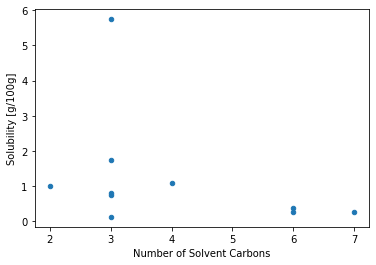

In [20]:
df.plot(x = "solvent_a_nC", y = "solubility_g_100g", kind="scatter", xlabel="Number of Solvent Carbons", ylabel="Solubility [g/100g]")

and its `matplotlib` equivalent:

Text(0.5, 0, 'Number of Solvent Carbons')

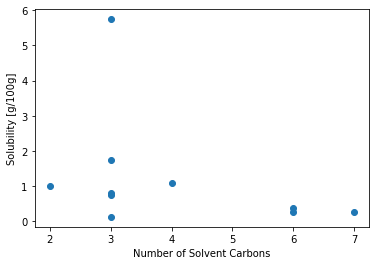

In [21]:
plt.figure()
plt.scatter(df["solvent_a_nC"], df["solubility_g_100g"])
plt.ylabel("Solubility [g/100g]")
plt.xlabel("Number of Solvent Carbons")

This is not to say that `matplotlib` shouldn't be used, it definitely should when you're not using `DataFrame`s, there is just an easier way to plot when using `DataFrame`s.

Create a bar chart looking at the number of carbons for each solvent.

<AxesSubplot:xlabel=' ', ylabel='Number of Carbons'>

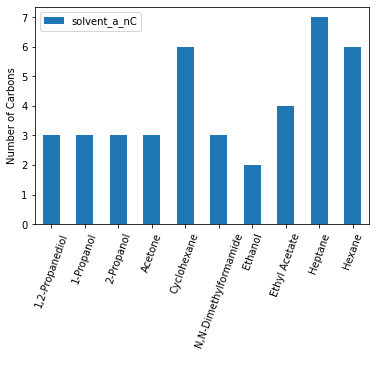

In [28]:
df.plot(x="solvent_name", y="solvent_a_nC", kind="bar", xlabel=" ", ylabel="Number of Carbons", rot=70)

### Exercise 1: Generating a List of Filenames

A very useful function in the `os` library is `listdir`. This will list the contents of a directory given the path provided to it as a string. For example,

In [29]:
os.listdir("solutes/")

['(2R,3R,4R,5S)-hexane-1,2,3,4,5,6-hexol.txt',
 '(2S)-5,7-dihydroxy-2-(3-hydroxy-4-methoxyphenyl)-2,3-dihydrochromen-4-one.txt',
 '(benzyldisulfanyl)methylbenzene.txt',
 '.ipynb_checkpoints',
 '1,3-benzenedicarboxylic acid.txt',
 '2,2-dichloro-n-((1s,2r)-1-(fluoromethyl)-2-hydroxy-2-(4-(methylsulfonyl)phenyl)ethyl)acetamide.txt',
 '2-(2-bromoethoxy)-1,3,5-trichlorobenzene.txt',
 '2-aminoacetic acid.txt',
 '2-aminopyridine.txt',
 '2-hydroxy-1,2-diphenylethanone.txt',
 '2-hydroxypropane-1,2,3-tricarboxylic acid.txt',
 '2-[(6-oxobenzo[c][2,1]benzoxaphosphinin-6-yl)methyl]butanedioic acid.txt',
 '3,4-dimethoxybenzoic acid.txt',
 '3-((6-O-(6-deoxy-alpha-L-mannopyranosyl)-beta-D-glucopyranosyl)oxy)-2-(3,4-dihydroxyphenol)-5,7-dihydroxy-4H-1-benzopyran-4-one.txt',
 '3-pyridinecarboxylic acid.txt',
 '3-[bis(3-hydroxypropyl)phosphoryl]propan-1-ol.txt',
 '311-03-5.txt',
 '4,5-bis(hydroxymethyl)-2-methylpyridin-3-ol.txt',
 '4-aminobenzoic acid.txt',
 '4-hydroxy-3-methoxybenzaldehyde.txt',
 '4-Hyd

N.B. since we just directly imported `os` we must do `os.listdir` to use the function.

As seen above we have created a list of the filenames. This is only half the battle of wanting to read in the data however as we know that the filename given to `read_csv` must also include the path to the file.

Using either a `for` loop or a list comprehension, generate the list of filenames needed for `read_csv` to be able to open the data e.g. where `os.listdir` returns `triclosan.txt` we would like it to read `solutes/triclosan.txt` in our list. Remember strings can be added so that `"solutes/" + "triclosan.txt"` = `"solutes/triclosan.txt"`.

In [34]:
filenames = []
for x in os.listdir("solutes/"):
    if ".txt" in x:
        filenames.append("solutes/"+x)

In [33]:
filenames = ["solutes/"+x for x in os.listdir("solutes/") if ".txt" in x]

### Exercise 2: Reading in the Data to a List of DataFrames

Similarly to Exercise 3 in the `intro_to_python.ipynb` notebook, use either a `for` loop or a list comprehension to create a list of Pandas DataFrames for each file.

In [35]:
dfs = []
for file in filenames:
    dfs.append(pd.read_csv(file, delimiter="\t"))

In [36]:
dfs = [pd.read_csv(file, delimiter="\t") for file in filenames]

### Exercise 3: Agglomerating the Data into a Large DataFrame

Multiple `DataFrame`s can be combined easily using the `pd.concat` function e.g. [here](https://stackoverflow.com/questions/32444138/concatenate-a-list-of-pandas-dataframes-together). Since the columns for all of our files are the same this can be used pretty much out of the box, however use the argument `ignore_index=True`. This counts the rows of the new, bigger data frame from 0 to number of rows - 1. (It is `False` by default which means when you get to each new file added to the list the counting starts from 0 for that file meaning if you were to do `.loc[0]` it would return an error).

In [37]:
df = pd.concat(dfs, ignore_index=True)

### Exercise 4: Removal of Unwanted Columns

There are 30 columns in our dataset and 633 rows. Not all of the columns will be useful for the analysis of the data we will do this afternoon. As such we can create a new `DataFrame` omitting these columns to be overencumbered with unnecessary data. Particularly, we do not need the `solvent_chem_id`, `solute_chem_id`, `solute_smiles`, `solvent_smiles`, `DHFUS_kj_mol`, `Tmelt_C`, `solubility_g_100g_log`, `cosmo_solubility_g_100g` and `cosmo_solubility_g_100g_log` columns. This is done using the `.drop` function e.g. say we wanted to get rid of only the `solvent_chem_id` and `solute_chem_id` columns we could do the following

In [38]:
new_df = df.drop(columns=["solvent_chem_id", "solute_chem_id"])

In [39]:
new_df

,solvent_name,solute_name,solute_smiles,solvent_smiles,DHFUS_kj_mol,Tmelt_C,solubility_g_100g,solubility_g_100g_log,cosmo_solubility_g_100g,cosmo_solubility_g_100g_log,...,solute_TPSA,solvent_a_nC,solvent_a_nN,solvent_a_nO,solvent_b_heavy,solvent_b_rotN,solvent_lip_acc,solvent_lip_don,solvent_rings,solvent_TPSA
0,1-Propanol,"(2R,3R,4R,5S)-hexane-1,2,3,4,5,6-hexol",O[C@@H]([C@@H](O)[C@@H](O)CO)[C@H](O)CO,OCCC,35.000000,92.699997,0.375750,-0.425101,12.826777,1.108118,...,121.38,3,0,1,3,1,1,1,0,20.230000
1,Acetone,"(2R,3R,4R,5S)-hexane-1,2,3,4,5,6-hexol",O[C@@H]([C@@H](O)[C@@H](O)CO)[C@H](O)CO,O=C(C)C,35.000000,92.699997,0.119860,-0.921326,12.957563,1.112523,...,121.38,3,0,1,3,0,1,0,0,17.070000
2,1-Butanol,"(2R,3R,4R,5S)-hexane-1,2,3,4,5,6-hexol",O[C@@H]([C@@H](O)[C@@H](O)CO)[C@H](O)CO,OCCCC,35.000000,92.699997,0.220160,-0.657262,5.598446,0.748067,...,121.38,4,0,1,4,2,1,1,0,20.230000
3,Acetonitrile,"(2R,3R,4R,5S)-hexane-1,2,3,4,5,6-hexol",O[C@@H]([C@@H](O)[C@@H](O)CO)[C@H](O)CO,N#CC,35.000000,92.699997,0.092300,-1.034704,5.496873,0.740116,...,121.38,2,1,0,2,0,1,0,0,23.790001
4,Methanol,"(2R,3R,4R,5S)-hexane-1,2,3,4,5,6-hexol",O[C@@H]([C@@H](O)[C@@H](O)CO)[C@H](O)CO,OC,35.000000,92.699997,3.347240,0.524687,68.851608,1.837914,...,121.38,1,0,1,1,0,1,1,0,20.230000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,1-Butanol,trimethoprim,O(C)c1c(OC)cc(Cc2c(N)nc(N)nc2)cc1OC,OCCCC,49.799999,472.899990,0.248834,-0.604090,0.001690,-2.773135,...,105.51,4,0,1,4,2,1,1,0,20.230000
629,2-Butanol,trimethoprim,O(C)c1c(OC)cc(Cc2c(N)nc(N)nc2)cc1OC,OC(CC)C,49.799999,472.899990,0.220364,-0.656859,0.001440,-2.841330,...,105.51,4,0,1,4,1,1,1,0,20.230000
630,Methanol,trimethoprim,O(C)c1c(OC)cc(Cc2c(N)nc(N)nc2)cc1OC,OC,49.799999,472.899990,1.568378,0.195451,0.019000,-1.721827,...,105.51,1,0,1,1,0,1,1,0,20.230000
631,Tetrahydrofuran,trimethoprim,O(C)c1c(OC)cc(Cc2c(N)nc(N)nc2)cc1OC,O1CCCC1,49.799999,472.899990,0.472030,-0.326030,0.000353,-3.452225,...,105.51,4,0,1,5,0,1,0,1,9.229999


Now do the same but for **all** of the columns we want to remove.

In [40]:
new_df = df.drop(columns=["solvent_chem_id", "solute_chem_id", "solute_smiles", "solvent_smiles", "DHFUS_kj_mol", "Tmelt_C", "solubility_g_100g_log", "cosmo_solubility_g_100g", "cosmo_solubility_g_100g_log"])

### Exercise 5: Saving to a New File

Saving a `DataFrame` to an Excel file is easy thankfully and can be achieved by using the `.to_excel` function (there are a bunch of different ways to save a `DataFrame` see [here](https://pandas.pydata.org/docs/reference/io.html)). e.g.

```
new_df.to_excel("excel_filename.xlsx", index = False)
```

Remember to use `index = False` when saving the file if the row names are unimportant/do not exist, otherwise Pandas will create a new column with just these index numbers in that don't mean anything.

In [41]:
new_df.to_excel("solubility.xlsx", index=False)